In [1]:
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

#### Load Data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.CIFAR10(root='./data', train=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Split the train data in to train data and validation data

indices = list(range(len(train_set)))
np.random.shuffle(indices)

valid_size = 0.2
split = int(valid_size*len(train_set))

train_idx, valid_idx = indices[split:], indices[:split]

## sampler for obtaining train and validation data 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

## load data 
train_loader = DataLoader(train_set, batch_size=64, sampler=train_sampler)
valid_loader = DataLoader(train_set, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(test_set, batch_size=64)

#### Visualize data

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

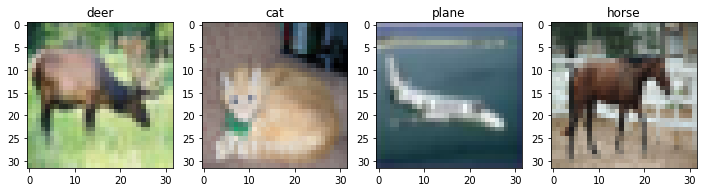

In [5]:
fig = plt.figure(figsize=(12,4))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    imshow(images[i])
    ax.set_title(classes[labels[i].item()])

### CNN architecture

In [6]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        # input image size 32*32*3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv sees 16*16*16 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
         # conv sees 8*8*32 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling 
        self.pool = nn.MaxPool2d(2, 2)
        # full connected layer 64*4*4
        self.fc1 = nn.Linear(64*4*4, 500)
        # last layer
        self.fc2 = nn.Linear(500, 10)
        # drop out layer
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten 
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

#### Specify loss function and optimizer

In [7]:
model = cnn()

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#### Train the neural network

In [8]:
train_losses , valid_losses = [], []
epochs = 20
valid_loss_min = np.inf
for epoch in range(epochs):
    train_loss , valid_loss = 0.0, 0.0
    ### training data
    model.train()
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    ## Validation
    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
    
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))
            
    print("---------Epoch:{}--------".format(epoch+1))
    print("Training loss :{}, Validation loss :{} ".format(train_loss/len(train_loader), 
                                                           valid_loss/len(valid_loader)))
    print("-----------------------------")
    if valid_loss<valid_loss_min:
        torch.save(model.state_dict(), 'cnn_cifar.pt')
        valid_loss_min = valid_loss

---------Epoch:1--------
Training loss :1.473854698085785, Validation loss :1.1567248337587732 
-----------------------------
---------Epoch:2--------
Training loss :1.0827747579574585, Validation loss :0.9979655708476995 
-----------------------------
---------Epoch:3--------
Training loss :0.9036998682022095, Validation loss :0.9028915216209022 
-----------------------------
---------Epoch:4--------
Training loss :0.788424014043808, Validation loss :0.8635411023334333 
-----------------------------
---------Epoch:5--------
Training loss :0.6914382159233093, Validation loss :0.8010593550220416 
-----------------------------
---------Epoch:6--------
Training loss :0.5984397989273071, Validation loss :0.8114883802878629 
-----------------------------
---------Epoch:7--------
Training loss :0.5145020880222321, Validation loss :0.8011275565927956 
-----------------------------
---------Epoch:8--------
Training loss :0.42820018849372865, Validation loss :0.8784493105426715 
---------------

#### load the model

In [34]:
model.load_state_dict(torch.load('cnn_cifar.pt'))

<All keys matched successfully>

#### Test the model

In [99]:
test_loss = 0.0
class_correct = np.zeros(10)
class_total = np.zeros(10)

model.eval()
for images, labels in test_loader:
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, predicted = torch.max(output, dim=1)
    correct = predicted.eq(labels).numpy().squeeze()
    for i in range(labels.shape[0]):
        lbl = labels[i]
        class_correct[lbl] += correct[i].item()
        class_total[lbl] += 1

print("Test Loss:{}".format(test_loss / len(test_loader)))
                       
for i in range(10):
    print("Test Accuracy of class {} is :{}% ({}/{})".format(classes[i], 100*class_correct[i] / class_total[i],
                                                            int(class_correct[i]), int(class_total[i])))

Test Loss:0.8310179414263197
Test Accuracy of class plane is :75.6% (756/1000)
Test Accuracy of class car is :80.6% (806/1000)
Test Accuracy of class bird is :56.5% (565/1000)
Test Accuracy of class cat is :46.2% (462/1000)
Test Accuracy of class deer is :70.6% (706/1000)
Test Accuracy of class dog is :57.0% (570/1000)
Test Accuracy of class frog is :86.5% (865/1000)
Test Accuracy of class horse is :74.5% (745/1000)
Test Accuracy of class ship is :81.5% (815/1000)
Test Accuracy of class truck is :82.8% (828/1000)


#### Visual few test images

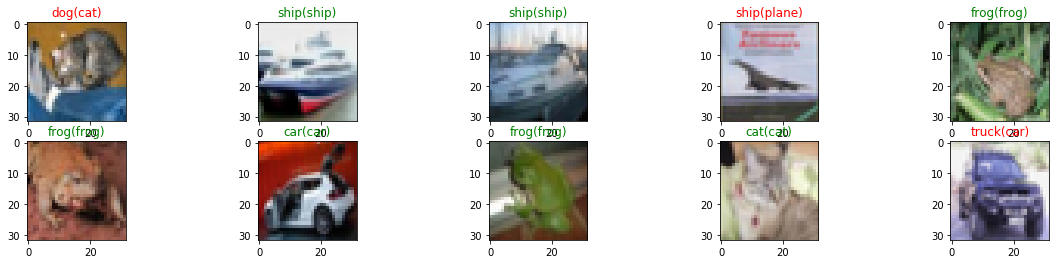

In [123]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, dim=1)

fig = plt.figure(figsize=(20,4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    imshow(images[i])
    ax.set_title("{}({})".format(classes[preds[i]], classes[labels[i].item()]),
                color = ('green' if classes[preds[i]]==classes[labels[i].item()] else 'red'))